# Image captioning is a supervised learning as we are generating captions based on our input of image.

Cloning Github repository as the dataset is so large.

In [ ]:
! git clone "https://github.com/Anand-Raj-CSE/B.Tech.-Projects.git"

Cloning into 'B.Tech.-Projects'...
remote: Enumerating objects: 11273, done.
remote: Counting objects: 100% (3160/3160), done.
remote: Compressing objects: 100% (2804/2804), done.
remote: Total 11273 (delta 331), reused 3157 (delta 330), pack-reused 8113
Receiving objects: 100% (11273/11273), 1.11 GiB | 35.57 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Checking out files: 100% (11271/11271), done.


In [ ]:
import pandas as pd

In [ ]:
def readTextFile(path):
  with open(path) as f:
    captions = f.read()
  return captions

In [ ]:
captions = readTextFile("/content/B.Tech.-Projects/MAJOR PROJECTS/Image Captioning Bot/Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
print(captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Checking number of captions
len(captions.split("\n"))

40461

In [ ]:
# Now splitting all the captions around new line
captions = captions.split('\n')

In [ ]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
captions[-1]

''

We can see that last line is empty so we can remove that by slicing.First executed cell 4

In [ ]:
captions = readTextFile("/content/B.Tech.-Projects/MAJOR PROJECTS/Image Captioning Bot/Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
print(captions)
captions = captions.split('\n')[:-1]
len(captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40460

Lets create a dictionary to map each Image with list of captions each has. Here in the dictionary, key is Imaage Id and values are the list of captions the image has. Captions and images are split by \t. We can then further split by . to get the image name only

In [ ]:
first,second = captions[0].split('\t')
print(first)
print(first.split('.'))
print(first.split('.')[0])

1000268201_693b08cb0e.jpg#0
['1000268201_693b08cb0e', 'jpg#0']
1000268201_693b08cb0e


In [ ]:
descriptions = {}
for x in captions:
  first_part,second_part = x.split('\t')
  image_name = first_part.split('.')[0]

  # Looking if the image id is already present or not
  if descriptions.get(image_name) is None:
    descriptions[image_name] = []

  descriptions[image_name].append(second_part)

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

Importing Images 

In [ ]:
Image_path = "/content/B.Tech.-Projects/MAJOR PROJECTS/Image Captioning Bot/Dataset/Flickr_Data/Flickr_Data/Images"

In [ ]:
import cv2
import matplotlib.pyplot as plt

As cv2 reads images in BGR form so we need to specify that read images in RGB.

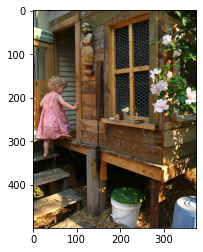

In [ ]:
img = cv2.imread(Image_path+"/1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Data Cleaning

In [ ]:
import numpy as np
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Earlier we used to remove stop words so here in captioning and hence we need not remove stop words as the model will not create correct english. Also we will not do stemming as in stemmig running becomes run so also its not correct english. This would also help to reduce the vocabulary size. We would remove special characters, number , punctuations
 as well. Reduction in vocab size is very important as we would do probablity distribution and hence less parameters.

In [ ]:
# data cleaning
def clean_text(sentence):
  sentence = sentence.lower()
  sentence = re.sub("[^a-z]+"," ",sentence) # Replace every non alphabetic character with space using regular expressions.
  sentence =sentence.split()
  # Remove all the words whicch have length of one
  sentence = [s for s in sentence if len(s)>1]
  sentence = " ".join(sentence)
  return sentence


In [ ]:
clean_text("A cat is sitting over the house number 64")

'cat is sitting over the house number'

In [ ]:
# clean all the captions
for key,caption_list in descriptions.items():
  for i in range(len(caption_list)): # Iterate over all the captions of the image
    caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# Write the data to a text file so that we need
with open("descriptions_1.txt","w") as f:
  f.write(str(descriptions))

Creating a Vocabulary , set of all unique words our model can predict.

In [ ]:
descriptions = None
with open("descriptions_1.txt","r") as f:
  descriptions = f.read()


Lets convert this into a python dictionary by first converting them into json and then to dictionary.

In [ ]:
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

Time to create vocab

In [ ]:
vocab = set()
vocab.update(["hello"])
vocab.update(["hi"])
vocab.update(["hello"])
print(vocab)

{'hi', 'hello'}


In [ ]:
vocab = set()
for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Length of vocabulary is : %d"%len(vocab))


Length of vocabulary is : 8424


sentence is a caption maped with the key of descriptions.

Removing words that have a frequecy less than a particular threshold , i.e very infrequent words are going to be removed.

In [ ]:
total_words = []
for key in descriptions.keys():
  [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total words are : %d"%len(total_words))


Total words are : 373837


out of 364140 words there are only 8917 unique words. So we would filter worlds that appear less than a certain threshold frequency.

In [ ]:
import collections
counter = collections.Counter(total_words) #count each word occurance
freq_count = dict(counter)
print(len(freq_count.keys()))

8424


In [ ]:
print(len(freq_count))

8424


In [ ]:
print(counter)

Counter({'in': 18987, 'the': 18420, 'on': 10746, 'is': 9345, 'and': 8863, 'dog': 8138, 'with': 7765, 'man': 7275, 'of': 6723, 'two': 5643, 'white': 3959, 'black': 3848, 'boy': 3581, 'are': 3505, 'woman': 3403, 'girl': 3328, 'to': 3176, 'wearing': 3062, 'at': 2916, 'people': 2887, 'water': 2790, 'red': 2691, 'young': 2630, 'brown': 2578, 'an': 2432, 'his': 2357, 'blue': 2279, 'dogs': 2125, 'running': 2073, 'through': 2032, 'playing': 2008, 'while': 1968, 'shirt': 1962, 'down': 1843, 'standing': 1789, 'ball': 1783, 'little': 1768, 'grass': 1622, 'snow': 1547, 'child': 1545, 'person': 1542, 'jumping': 1473, 'over': 1415, 'three': 1389, 'front': 1386, 'sitting': 1368, 'holding': 1324, 'up': 1302, 'field': 1283, 'small': 1278, 'by': 1249, 'large': 1237, 'green': 1234, 'one': 1223, 'group': 1218, 'yellow': 1217, 'her': 1178, 'walking': 1165, 'children': 1156, 'men': 1121, 'into': 1074, 'air': 1062, 'beach': 1046, 'near': 1026, 'mouth': 989, 'jumps': 979, 'another': 956, 'for': 950, 'street':

In [ ]:
# Sorting the dictionary according to frequency count
sorted_frequency_count = sorted(freq_count.items(),reverse=True,key = lambda x:x[1])

In [ ]:
# Filtering according to threshold frequency
threshold = 10
sorted_frequency_count = [x for x in sorted_frequency_count if x[1]>threshold]
print(len(sorted_frequency_count))

1845


In [ ]:
total_words = [x[0] for x in sorted_frequency_count]
total_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

In [ ]:
print(len(total_words))

1845


Prepare Train Test data

In [ ]:
train_file_data = readTextFile("/content/B.Tech.-Projects/MAJOR PROJECTS/Image Captioning Bot/Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/B.Tech.-Projects/MAJOR PROJECTS/Image Captioning Bot/Dataset/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [ ]:
# splitting the data which is in next line and removing .jpg extension
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train[:10])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154']


In [ ]:
# splitting the data which is in next line and removing .jpg extension
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(test[:10])

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


We must add start and end token at every starting nad ending of a sentence will which will denote a sentence. End token must be added as it will denote ending for a given layer of perceptron.

In [ ]:
train_descriptions = {}
for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_append = "startseq " + cap + " endseq"
    train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

Transfer Learning - changing images and text to features. We would use Restnet - 50 , it has 50 layers which are very sufficient and has no vanishing gradient problem so they can back propagate easily.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102981632/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

here avg_pool (GlobalAveragePooling  (None, 2048) is a list of 2048 items that has value of one layer of 7*7 which came from conv5_block3_out(activavtion) layer.

In [ ]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
# model.input corresponds to input layer of api
model_new = Model(model.input,model.layers[-2].output) # here we want our output from the second last layer, avg_pool

Now we are feeding imagesof m size then should give m*2048 as output and this is our image feature vector and save it for later use.


In [ ]:
def preprocess_img(img):
  img = image.load_img(img,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0) # We cannot give 3 tensor and we need to give 4d tensores so we are adding 0th dimensions
  # Normalization , we would use preprocess image for this that is prebuild in ResNet50
  img = preprocess_input(img)
  return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


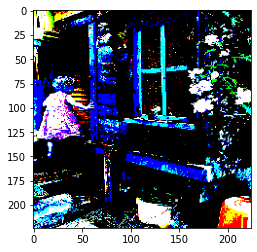

In [ ]:
img = preprocess_img(Image_path+"/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()

ResNet50 is unsing mean subtracting i.e mean over all the channels R,G,B is subtracted from each pixel and negative values are discarded from it. So now lets do it for all the images.

In [ ]:
def encode_image(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1,))

  print(feature_vector.shape)
  return feature_vector

In [ ]:
encode_image(Image_path+"/1000268201_693b08cb0e.jpg")

(2048,)


array([0.06535933, 0.1678256 , 0.3251759 , ..., 0.05107147, 0.3282118 ,
       1.004338  ], dtype=float32)

We can see that we are getting 2048 sized image , os we need to reshape the image accordingly in encode_image finction.

## We would now encode all our training and testing images and save it in a file for our future use.

In [ ]:
def encode_image(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1,))

  #print(feature_vector.shape)
  return feature_vector

In [ ]:
start_time = time()
encoding_train = {}
# for each image id we would store a feature vector extracted from ResNet50 image.
for ix,img_id in enumerate(train):
  img_path = Image_path+"/"+img_id+".jpg"
  encoding_train[img_id] = encode_image(img_path)

  if ix%100 == 0:
    print("Train Encoding in Progress Time step %d "%ix)

end_time = time()
print("Total time taken for training : ",end_time-start_time)

Train Encoding in Progress Time step 0 
Train Encoding in Progress Time step 100 
Train Encoding in Progress Time step 200 
Train Encoding in Progress Time step 300 
Train Encoding in Progress Time step 400 
Train Encoding in Progress Time step 500 
Train Encoding in Progress Time step 600 
Train Encoding in Progress Time step 700 
Train Encoding in Progress Time step 800 
Train Encoding in Progress Time step 900 
Train Encoding in Progress Time step 1000 
Train Encoding in Progress Time step 1100 
Train Encoding in Progress Time step 1200 
Train Encoding in Progress Time step 1300 
Train Encoding in Progress Time step 1400 
Train Encoding in Progress Time step 1500 
Train Encoding in Progress Time step 1600 
Train Encoding in Progress Time step 1700 
Train Encoding in Progress Time step 1800 
Train Encoding in Progress Time step 1900 
Train Encoding in Progress Time step 2000 
Train Encoding in Progress Time step 2100 
Train Encoding in Progress Time step 2200 
Train Encoding in Progr

# We would use pickle , it is used to save data from RAM to disk

In [ ]:
with open("encoded_train_features.pkl","wb") as f:
  pickle.dump(encoding_train,f)

We would do same for test data.

In [ ]:
start_time = time()
encoding_test = {}
# for each image id we would store a feature vector extracted from ResNet50 image.
for ix,img_id in enumerate(test):
  img_path = Image_path+"/"+img_id+".jpg"
  encoding_test[img_id] = encode_image(img_path)

  if ix%100 == 0:
    print("Test Encoding in Progress Time step %d "%ix)

end_time = time()
print("Total time taken for testing : ",end_time-start_time)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total time taken for testing :  66.77814841270447


In [ ]:
with open("encoded_test_features.pkl","wb") as f:
  pickle.dump(encoding_test,f)

# Data preprocessing for captions.

In [ ]:
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word

In [ ]:
print(word_to_idx["dog"])
idx_to_word[6]

6


'dog'

In [ ]:
idx_to_word[1]

'in'

Now we have to add start and end sequence in our dictionary of idx_to_word and word_to_idx

In [ ]:
print(len(idx_to_word))

1845


In [ ]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1846

# changing the size of our vocab
vocab_size = len(word_to_idx) + 1
print("Vocab Size : ",vocab_size)

Vocab Size :  1848


We are going to generate captions in batches as the size would depend upon the layers in which each layer produces a word in RNN model of layers . Here we are going to generate maximum length caption

In [ ]:
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len,len(cap.split()))

print(max_len)

35


We cannot generate all senetence all at once , there are start tokens and then first word is input for second layer at hence the at each layer we are predicting the words probability , this is called as language modelling. so train such models , we have very large corpus , we give lots of data and we give start token and that start token gives an output and the start token and 1st output id input for second one. So prediction is very important for us to predict correct word as ew need joint probability.

So for us we give image and from one exaple hass many training points in the image. Our probability of guessing the next word is maximized based on previously generated text. So goal is to predict a single word (number from vocab to table) , we would do batch  training to save disk and ram. We have 50 dimension words for a single word, using glove vector.

WE would generate our own data instead of using keras as we have specialized data which has captions and images.

In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  X1,X2,y = [],[],[]
  n=0
  while True:
    
    for key,desc_list in train_descriptions.items():
      n+=1
      
      photo = encoding_train[key]
      
      for desc in desc_list:
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
        
        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          # 0 here is padding word , post padding means that we are adding pads post sequences
          xi = pad_sequences([xi],maxlen = max_len,value=0,padding='post')[0]
          # This accepts a 2d list and also returns a 2d list
          yi = to_categorical([yi],num_classes=vocab_size)[0]
          #yi is one hot vector

          X1.append(photo)
          X2.append(xi)
          y.append(yi)

        if n == batch_size:
          yield[[np.array(X1),np.array(X2)],np.array(y)]

          X1,X2,y = [],[],[]

# suppose there are images that have 5 captions and has max of 7 length , and our batch size is 64 , so for 
# 1st caption we have 1*5*7 = 35 and then we have another 20*4  so in x1 we have photo and x2 has 35 ,   


lets see whats here , for id say abc.jpg has cap1,cap2 ...cap5. Say cap1 is Dog is running , then it would be like [13 , 46 , 41] in our idx_to_word dictionary , so fro given 13 our prediction should be 46 ,for given 13,46 our prediction should be 41. Later on we would do padding so that our whole vector is of same dimensions.

Word Embedding ,concept of transfer learning , here we would convert our numbers for our given words to something useful. Whenever we have RNN or LSTM layer teh we have to pass it through some embeddning layer and we use glove 60 50 D , it contains 60billion of each 50 dimensional vector , we would try to cinstruct the matrix for our dataset.

In [ ]:
# Reading file from drive 60 billion one
f = open("/content/drive/MyDrive/Word embedding 60 billion data/glove.6B.50d.txt",encoding = 'utf8')

In [ ]:
for line in f:
  values = line.split()
  print(values)
  break

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581']


We can see that , first word is word and rest are embeddings.

In [ ]:
embedding_index = {}
for line in f:
  values = line.split()

  word = values[0]
  word_embeddings = np.array(values[1:],dtype = 'float')
  embedding_index[word] = word_embeddings

In [ ]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
# closing the file
f.close()

here we are checking at what index in glove vector our given word is mapped to. Each roe is of size 50 ,if its none then rows will be 0

In [ ]:
def get_embedding_matrix():
  emb_dim = 50
  matrix = np.zeros((vocab_size,emb_dim))
  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector
  
  return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [ ]:
embedding_matrix[1847] # We would get 0's as there are no start and end sequences

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We have partial captiosn that has embedding features and that is passed to RNN layers and then a hideen vector is produced and that hidden vector is then combined with image vector having 2048 dimensions and we feed it feed forward neural network(MLP which has lots of layers) , MLP would predict what would be the next word.

# Model Architecture

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2) # 256 is the size of hidden vector given to LSTM

batchsize(B) * 35 -> B*35*50 -> LSTM -> 256 dim

In [ ]:
# Keras tensor Add layer
decoder1 = add([inp_img2,inp_cap3]) #256 vectors of RESnet 50 
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# combined model
model = Model(inputs = [input_img_features,input_captions],outputs = outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
# Importanat things in embedding
model.layers[2].set_weights([embedding_matrix])
#donot train these layers
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

# Training of Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def train():
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
train()

   5/2000 [..............................] - ETA: 29s - loss: 7.2949    

In [ ]:
model = load_model('./model_weights/model_p.h5')

NameError: ignored

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

NameError: ignored